# Precise localisation of the rotation axis in tomography 
(Auto-focus like approach)

### The idea of the algorithm is pretty simple:
 - Randomly choose the rotation axis (not really completely randomly, some initial guess is desired).
 - Reconstruct the tomo-slice.
 - Calculate the sharpness of the tomo-slice. Higher number of frequencies/ standard deviation of FFT corresponds to a sharper image. Check [this](https://doi.org/10.1016/j.patcog.2012.11.011) paper for alternative approaches .
 - Do it for several rotaxis numbers, pick the highest value of the standard deviation.

In [1]:
import numpy as np
import tomopy
from maximus48 import var
import matplotlib.pyplot as plt

data = '/Users/mpolikarpov/data_server/raw_data3/platy3/Platy-Platy_10105_proj.npy'
proj = np.load(data, mmap_mode = 'r')

the shape of the data is  (3599, 2028, 2560)


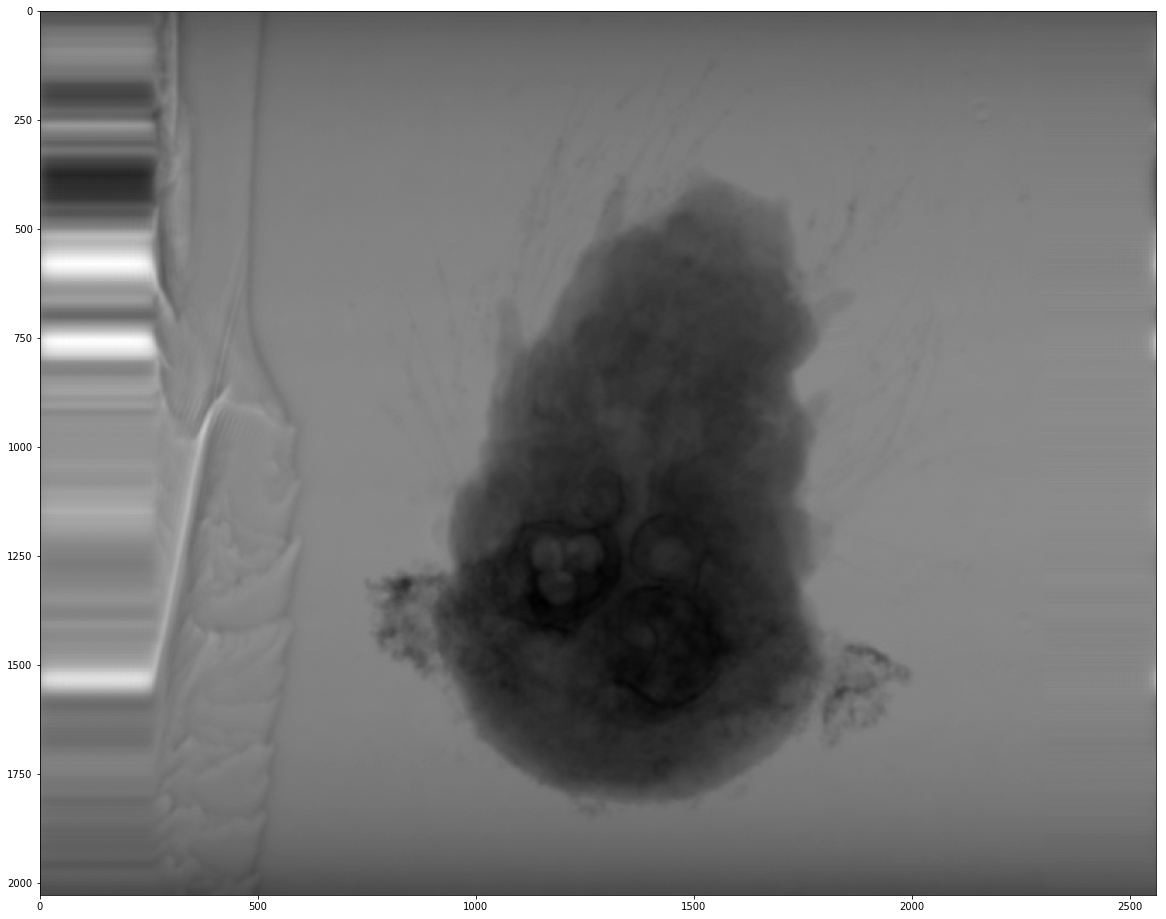

In [2]:
# one of the projections images in the dataset
var.show(proj[0])
print('the shape of the data is ', proj.shape)

This data is an X-ray tomogram, collected over 360 degrees with a 0.1 degree step (dim0 of numpy array)

In [3]:
from skimage.transform import rescale
from numpy.fft import fft2, fftshift
from maximus48.multiCTF2 import shift_distance as shift

# number of projections per degree
N_steps = 10                                                                

## Step 1 
Make rough alignment and search of the rotation axis

In [4]:
def rotaxis_rough(proj, N_steps = 10):
    
    """calculate the rotation axis comparing 0 and 180 projection shift
    proj: 3D array
    N_steps: Number of projections per degree
    by default it compares the central part of images (between 1/4 and 3/4 of shape)
    """
    
    a = proj.shape[1]//4
    b = 3 * proj.shape[1]//4
    c = proj.shape[2]//4
    d = 3 * proj.shape[2]//4
                
    cent = []
    N_rot = proj.shape[0] - 180 * N_steps
    
    for i in range(N_rot):
        distances = shift(proj[i, a:b, c:d], np.flip(proj[i + N_steps*180, a:b, c:d] ,1))
        cent.append(proj[i].shape[1]/2 + distances[1]/2)
    
    return cent

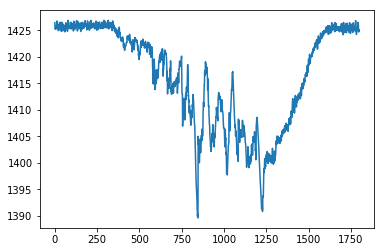

In [5]:
# rough alignment of the center
cent = rotaxis_rough(proj[:,1000:1002], N_steps)
plt.plot(cent)

You can see that it looks ugly. I don't know for sure why but I have a feeling that it happens because phase contast messes up the cross-correlation. But at least now we have an initial guess for rotation axis.

In [6]:
cent = np.median(cent)
print('initial guess for the rotation axis is ', cent)

initial guess for the rotation axis is  1419.615


## Step 2
Make fine registation

In [7]:
def rotaxis_precise(projections, rotaxis_scan_interval, rot_step = 10, downscale = 0.25):
    """
    This function calculates tomo-reconstructions and tells you 
    which tomo-slice is the sharpest one
   
    Parameters
    __________
    projections: 3D array
        0 direction is different images
    
    rotaxis_scan_interval: array
        range of integers for potential rotation axis values
    
    rot_step: int
        number of radiographic projections per 1 degree (typically 1 or 10)
        
    k: int
        rotaxis coordinate for the most sharpest image
    """
            
    # calculate angles
    n = projections.shape[0]
    angle = np.pi*np.arange(n)/(rot_step*180)
     
    # counter for best std
    elements = []
    # 0 direction to store rotaxis
    elements.append([])
    # 1 direction to store contrast values
    elements.append([])    
    
    # body
    for i in rotaxis_scan_interval:
        image = tomopy.recon(projections, angle, center = i, 
                             algorithm = 'gridrec', filter_name = 'shepp')[0]
        
        image = rescale(image, downscale, anti_aliasing=True, multichannel = False)
        image = np.std(np.log(abs(fftshift(fft2(image)))))
        elements[1].append(image)
        elements[0].append(i)
        
    return np.asarray(elements)

### Iteration 1 - broad scan

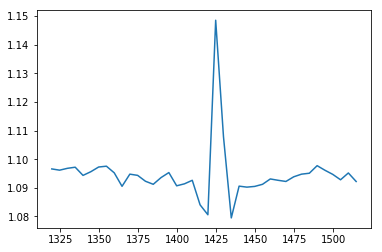

In [8]:
opa = rotaxis_precise(proj[:,1000:1001], np.arange(cent - 100, cent + 100, 5), rot_step = N_steps)
plt.plot(opa[0], opa[1])

In [10]:
# we pick the highest value
cent = opa[0][np.argmax(opa[1])]
print('center of otation is at', cent)

center of otation is at 1424.615


### Iteration 2 - finer scan

center of rotation is at 1425.914999999997


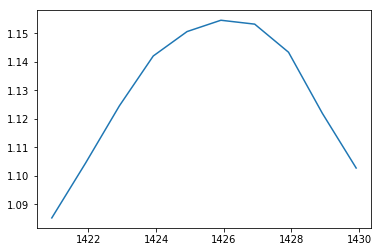

In [22]:
opa = rotaxis_precise(proj[:,1000:1001], np.arange(cent - 5, cent + 5, 1), rot_step = N_steps)
plt.plot(opa[0], opa[1])
cent = opa[0][np.argmax(opa[1])]
print('center of rotation is at', cent)

### Iteration 3 - the finest scan

center of rotation is at 1426.5149999999946


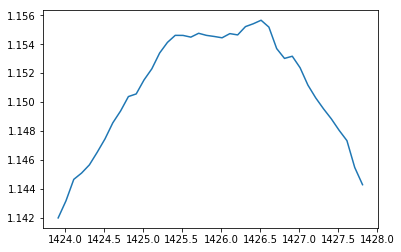

In [28]:
opa = rotaxis_precise(proj[:,1000:1001], np.arange(cent - 2, cent + 2, 0.1), rot_step = N_steps)
plt.plot(opa[0], opa[1])
cent = opa[0][np.argmax(opa[1])]
print('center of rotation is at', cent)

As you see above - sometimes local maxima do not correspo nd to the sharpest focus = not the center of the distribution.
So the general idea would be to fit it and use the 'ideal' coordinate from a fit.

final center of rotation is at 1426.114999999995


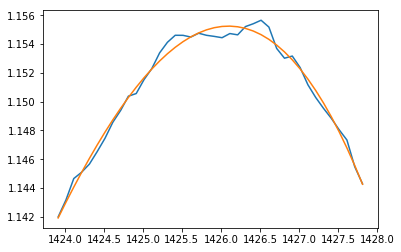

In [63]:
def fit_polynom(x, y, poly_deg):
    pfit = np.polyfit(x,y, poly_deg)
    return np.polyval(pfit, x)

# fit and plot
fit = fit_polynom(opa[0], opa[1], poly_deg = 3)
plt.plot(opa[0], opa[1], opa[0], fit)

# final center of rotation
cent = opa[0][np.argmax(fit)]
print('final center of rotation is at', cent)

That is it. One can put everything together with a simple function. 

### Put everything together

In [64]:
def rotaxis_scan(projections, rot_step = 10):
    """
    The function combines rotaxis_rough() and rotaxis_precise()
    It does three iterations to find the best match for the rotation axis
   
    Parameters
    __________
    projections: 3D array
        0 direction is different images. 
        Please note that 1st direction should have 2 or more values. 
        If it has >2 values, only the first slice will be considered 
            for resolution measurements
    rot_step: int
        number of radiographic projections per 1 degree (typically 1 or 10)
    cent: int
        center of rotation
    """
    
    # rough alignment
    cent = rotaxis_rough(projections, rot_step)
    cent = np.median(cent)

    # first iteration
    opa = rotaxis_precise(projections, np.arange(cent - 100, cent + 100, 5), rot_step)
    cent = opa[0, np.argmax(opa[1])]

    # second iteration
    opa = rotaxis_precise(projections, np.arange(cent - 5, cent + 5, 1), rot_step)
    cent = opa[0, np.argmax(opa[1])]
    
    # third iteration
    opa = rotaxis_precise(projections, np.arange(cent - 2, cent + 2, 0.1), rot_step)
    cent = opa[0, np.argmax(opa[1])]
    
    #final fit
    fit = fit_polynom(opa[0], opa[1], poly_deg = 3)
    cent = opa[0, np.argmax(fit)]
    
    return cent

In [66]:
# and now it is all done with one line of code
cent = rotaxis_scan(proj[:,1000:1002], rot_step = N_steps)
print(cent)

1426.1149999999986
